# Importing of packages

In [4]:
#packages
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.linalg import qr
from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge

# Functions used

In [51]:
#functions
def sketch_matrix(m, n_columns, non_zero_entries):
    #matrix with all zero entries
    S = np.zeros((m, n_columns))
    scaling_factor = 1 / np.sqrt(non_zero_entries)
    #loop through each columns to edit the non zero entries in
    for col in range(n_columns):
        # Randomly select position of non_zero entries
        nz_positions = np.random.choice(m, non_zero_entries, replace=False)
        
        # Randomly assign values of either 1 or -1 to these positions
        values = np.random.choice([1, -1], non_zero_entries)* scaling_factor
        
        # Assign the values to the selected positions in the column
        for idx, value in zip(nz_positions, values):
            S[idx, col] = value
    
    return S

def svd_sketching_error(S):
    # Compute singular values
    singular_values = np.linalg.svd(S, compute_uv=False)

    # Min and max singular values
    min_svd = np.min(singular_values)
    max_svd = np.max(singular_values)

    # Compute deviations from 1
    min_svd_error = abs(1 - min_svd)
    max_svd_error = abs(1 - max_svd)

    return min_svd_error, max_svd_error

#svd of matrix
def compute_svd(matrix):
    # SVD computation only keep the singular values
    _, s, _ = np.linalg.svd(matrix, full_matrices=False)
    return np.min(s), np.max(s)

#Higher leverage scores indicate more influential data points.
def estimate_leverage_scores(A, R, gamma):
    """Estimate leverage scores ˜li for each row using matrix R (similar to Lemma 5.1)."""
    n, d = A.shape
    k = int(np.ceil(d / gamma))  # Choose k based on γ
    G = np.random.randn(d, k) / np.sqrt(k) #scale the matrix
    
    # Compute the leverage scores ˜li = || e_i^T AR G ||_2^2
    ARG = A @ (R @ G)
    leverage_scores = np.sum(ARG ** 2, axis=1)  # || e_i^T AR G ||_2^2
    
    return leverage_scores

def fast_least_squares_sgd(A, b, non_zero_entries, m, T=100, eta=0.01, gamma=0.1, batch_size=10):
    """
    Fast least squares via preconditioned mini-batch SGD using sketch matrix and leverage scores.
    
    Parameters:
    - A: (n, d) NumPy array (or sparse matrix), the design matrix.
    - b: (n,) NumPy array, the target vector.
    - T: Number of SGD iterations.
    - eta: Learning rate.
    - gamma: Approximation parameter for leverage score estimation.
    - batch_size: Number of rows sampled per SGD iteration.
    
    Returns:
    - x: (d,) NumPy array, the estimated least squares solution.
    """
    n, d = A.shape
    A = np.c_[np.ones(n), A] #for intercept

    # Step 1: Generate the sketch matrix S using the sketch_matrix function
    S = sketch_matrix(m, n, non_zero_entries)
    # Step 2: Compute SA and Sb
    SA = S @ A
    Sb = S @ b
    min_svd_error, max_svd_error = svd_sketching_error(SA)

    # Step 3: Compute QR decomposition of SA
    Q, R_inv = np.linalg.qr(SA)
    R = np.linalg.inv(R_inv)

    # Step 4: Compute leverage score estimates
    leverage_scores = estimate_leverage_scores(A, R, gamma)
    leverage_probs = leverage_scores / np.sum(leverage_scores)  # Normalize

    # Step 5: Compute initial x0 by solving (SAx = Sb)
    x = np.linalg.lstsq(SA, Sb, rcond=None)[0]

    # Step 6: Perform mini-batch SGD
    for t in range(T):
        # Step 6.1: Sample batch indices based on leverage scores
        batch_indices = np.random.choice(n, size=batch_size, p=leverage_probs)
        
        # Step 6.2: Construct StA and Stb for mini-batch
        StA = A[batch_indices]
        Stb = b[batch_indices]

        # Step 6.3: Compute gradient of the least squares loss
        gt = 2 * StA.T @ (StA @ x - Stb)

        # Step 6.4: Update x using preconditioned gradient
        x = x - eta * R @ (R.T @ gt)
    intercept = x[0]

    return x[1:] , intercept, min_svd_error , max_svd_error

def compute_effective_dimension(A, lambda_reg):
    """Computes the lambda-effective dimension d_lambda."""
    d = A.shape[1]
    I = np.eye(d)
    return np.trace(A.T @ A @ np.linalg.inv(A.T @ A + lambda_reg * I))

def fast_least_squares_sgd_regularized(A, b, non_zero_entries, m, lambda_reg, T=100, eta=0.01, gamma=0.1, batch_size=10):
    """
    Implements fast least squares using mini-batch SGD with scaled regularization.

    Parameters:
    - A: (n, d) NumPy array (design matrix).
    - b: (n,) NumPy array (target vector).
    - lambda_reg: Regularization parameter λ.
    - m: Sketching matrix size.
    
    Returns:
    - x: (d,) NumPy array (estimated solution).
    """
    n, d = A.shape
    
    # Step 1: Compute effective dimension and scaled regularization λ'
    d_lambda = compute_effective_dimension(A, lambda_reg)
    lambda_scaled = lambda_reg * (1 - d_lambda / m)

    # Step 2: Generate sketch matrix
    S = sketch_matrix(m, n, non_zero_entries)
    min_svd_error, max_svd_error = svd_sketching_error(S)
    
    # Step 3: Compute SA and Sb
    SA = S @ A
    Sb = S @ b

    # Step 4: Compute QR decomposition of SA
    Q, R_inv = np.linalg.qr(SA)
    R = np.linalg.inv(R_inv)

    # Step 5: Compute leverage scores
    leverage_scores = estimate_leverage_scores(A, R, gamma)
    leverage_probs = leverage_scores / np.sum(leverage_scores)  # Normalize

    # Step 6: Solve for initial x0 using regularized least squares
    I_d = np.eye(d)
    x = np.linalg.solve(SA.T @ SA + lambda_scaled * I_d, SA.T @ Sb)

    # Step 7: Perform mini-batch SGD
    for t in range(T):
        # Sample batch indices based on leverage scores
        batch_indices = np.random.choice(n, size=batch_size, p=leverage_probs)
        
        # Construct StA and Stb for mini-batch
        StA = A[batch_indices]
        Stb = b[batch_indices]

        # Compute gradient with regularization
        gt = 2 * (StA.T @ (StA @ x - Stb) + lambda_scaled * x)

        # Update x using preconditioned gradient
        x = x - eta * R @ (R.T @ gt)

    return x, lambda_scaled, min_svd_error , max_svd_error

In [28]:
#functions
def sketch_matrix(m, n_columns, non_zero_entries):
    #matrix with all zero entries
    S = np.zeros((m, n_columns))
    scaling_factor = 1 / np.sqrt(non_zero_entries)
    #loop through each columns to edit the non zero entries in
    for col in range(n_columns):
        # Randomly select position of non_zero entries
        nz_positions = np.random.choice(m, non_zero_entries, replace=False)
        
        # Randomly assign values of either 1 or -1 to these positions
        values = np.random.choice([1, -1], non_zero_entries)* scaling_factor
        
        # Assign the values to the selected positions in the column
        for idx, value in zip(nz_positions, values):
            S[idx, col] = value
    
    return S

def svd_sketching_error(A, S):
    """
    Computes the SVD-based sketching error by comparing the singular values of
    the original matrix A and the sketched matrix SA.
    - Deviation of max singular value from the original matrix's max singular value
    - Deviation of min singular value from the original matrix's min singular value

    Parameters:
    A (numpy.ndarray): The original matrix.
    S (numpy.ndarray): The sketch matrix.

    Returns:
    tuple: (1 - min_singular_value_error, 1 - max_singular_value_error)
    """
    # Compute singular values of the original matrix A
    singular_values_A = np.linalg.svd(A, compute_uv=False)

    # Compute the sketched matrix SA
    SA = S @ A

    # Compute singular values of the sketched matrix SA
    singular_values_SA = np.linalg.svd(SA, compute_uv=False)

    # Min and max singular values of the original matrix A
    min_svd_A = np.min(singular_values_A)
    max_svd_A = np.max(singular_values_A)

    # Min and max singular values of the sketched matrix SA
    min_svd_SA = np.min(singular_values_SA)
    max_svd_SA = np.max(singular_values_SA)

    # Compute deviations from the original matrix's singular values
    min_svd_error = abs(1 - (min_svd_SA / min_svd_A))
    max_svd_error = abs(1 - (max_svd_SA / max_svd_A))

    return min_svd_error, max_svd_error

#svd of matrix
def compute_svd(matrix):
    # SVD computation only keep the singular values
    _, s, _ = np.linalg.svd(matrix, full_matrices=False)
    return np.min(s), np.max(s)

#Higher leverage scores indicate more influential data points.
def estimate_leverage_scores(A, R, gamma):
    """Estimate leverage scores ˜li for each row using matrix R (similar to Lemma 5.1)."""
    n, d = A.shape
    k = int(np.ceil(d / gamma))  # Choose k based on γ
    G = np.random.randn(d, k) / np.sqrt(k) #scale the matrix
    
    # Compute the leverage scores ˜li = || e_i^T AR G ||_2^2
    ARG = A @ (R @ G)
    leverage_scores = np.sum(ARG ** 2, axis=1)  # || e_i^T AR G ||_2^2
    
    return leverage_scores

def fast_least_squares_sgd(A, b, non_zero_entries, m, T=100, eta=0.01, gamma=0.1, batch_size=10):
    """
    Fast least squares via preconditioned mini-batch SGD using sketch matrix and leverage scores.
    
    Parameters:
    - A: (n, d) NumPy array (or sparse matrix), the design matrix.
    - b: (n,) NumPy array, the target vector.
    - T: Number of SGD iterations.
    - eta: Learning rate.
    - gamma: Approximation parameter for leverage score estimation.
    - batch_size: Number of rows sampled per SGD iteration.
    
    Returns:
    - x: (d,) NumPy array, the estimated least squares solution.
    """
    n, d = A.shape
    # Add a column of ones to A to include intercept term
    A = np.c_[np.ones(n), A]
    print(A.shape)

    # Step 1: Generate the sketch matrix S using the sketch_matrix function
    S = sketch_matrix(m, n, non_zero_entries)
    min_svd_error, max_svd_error = svd_sketching_error(A,S)
    # Step 2: Compute SA and Sb
    SA = S @ A
    Sb = S @ b

    # Step 3: Compute QR decomposition of SA
    Q, R_inv = np.linalg.qr(SA)
    R = np.linalg.inv(R_inv)

    # Step 4: Compute leverage score estimates
    leverage_scores = estimate_leverage_scores(A, R, gamma)
    leverage_probs = leverage_scores / np.sum(leverage_scores)  # Normalize

    # Step 5: Compute initial x0 by solving (SAx = Sb)
    x = np.linalg.lstsq(SA, Sb, rcond=None)[0]

    # Step 6: Perform mini-batch SGD
    for t in range(T):
        # Step 6.1: Sample batch indices based on leverage scores
        batch_indices = np.random.choice(n, size=batch_size, p=leverage_probs)
        
        # Step 6.2: Construct StA and Stb for mini-batch
        StA = A[batch_indices]
        Stb = b[batch_indices]

        # Step 6.3: Compute gradient of the least squares loss
        gt = 2 * StA.T @ (StA @ x - Stb)

        # Step 6.4: Update x using preconditioned gradient
        x = x - eta * R @ (R.T @ gt)
    intercept = x[0]

    return x[1:] , intercept, min_svd_error , max_svd_error

def compute_effective_dimension(A, lambda_reg):
    """Computes the lambda-effective dimension d_lambda."""
    d = A.shape[1]
    I = np.eye(d)
    return np.trace(A.T @ A @ np.linalg.inv(A.T @ A + lambda_reg * I))

def fast_least_squares_sgd_regularized(A, b, non_zero_entries, m, lambda_reg, T=100, eta=0.01, gamma=0.1, batch_size=10):
    """
    Implements fast least squares using mini-batch SGD with scaled regularization.

    Parameters:
    - A: (n, d) NumPy array (design matrix).
    - b: (n,) NumPy array (target vector).
    - lambda_reg: Regularization parameter λ.
    - m: Sketching matrix size.
    
    Returns:
    - x: (d,) NumPy array (estimated solution).
    """
    n, d = A.shape
    
    # Step 1: Compute effective dimension and scaled regularization λ'
    d_lambda = compute_effective_dimension(A, lambda_reg)
    lambda_scaled = lambda_reg * (1 - d_lambda / m)

    # Step 2: Generate sketch matrix
    S = sketch_matrix(m, n, non_zero_entries)
    min_svd_error, max_svd_error = svd_sketching_error(A,S)
    
    # Step 3: Compute SA and Sb
    SA = S @ A
    Sb = S @ b

    # Step 4: Compute QR decomposition of SA
    Q, R_inv = np.linalg.qr(SA)
    R = np.linalg.inv(R_inv)

    # Step 5: Compute leverage scores
    leverage_scores = estimate_leverage_scores(A, R, gamma)
    leverage_probs = leverage_scores / np.sum(leverage_scores)  # Normalize

    # Step 6: Solve for initial x0 using regularized least squares
    I_d = np.eye(d+1)
    x = np.linalg.solve(SA.T @ SA + lambda_scaled * I_d, SA.T @ Sb)

    # Step 7: Perform mini-batch SGD
    for t in range(T):
        # Sample batch indices based on leverage scores
        batch_indices = np.random.choice(n, size=batch_size, p=leverage_probs)
        
        # Construct StA and Stb for mini-batch
        StA = A[batch_indices]
        Stb = b[batch_indices]

        # Compute gradient with regularization
        gt = 2 * (StA.T @ (StA @ x - Stb) + lambda_scaled * x)

        # Update x using preconditioned gradient
        x = x - eta * R @ (R.T @ gt)

    intercept = x[0]

    return x[1:], intercept, lambda_scaled, min_svd_error , max_svd_error

In [220]:
sketch_matrix(5,3,1)

array([[ 0., -1.,  0.],
       [ 0.,  0.,  0.],
       [-1.,  0., -1.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])

# Effects of sparsity and number of rows on mse and sketching error

## m against mse and sketching error

In [52]:
n, d = 10000, 100 
m = min(2 * d, n)  # Typically 2d rows for sketch matrix
non_zero_entries = 10
A = np.random.randn(n, d)  # Design matrix A
x_true = np.random.randn(d)  # True solution vector x
b = A @ x_true + np.random.randn(n) * 0.1


# Estimate the solution using the algorithm
x_estimated,  _, _ = fast_least_squares_sgd(A, b, 10, m)

In [47]:
#varying m
# Define parameters
n, d = 10000, 100  # Matrix size
m_values = list(range(100,7000 + 1, 100))  # Different sketch sizes
non_zero_entries = 10
# Store results
results = []
# Generate new A and b
A = np.random.randn(n, d)
x_true = np.random.randn(d)
b = A @ x_true + np.random.randn(n) * 0.1

for m in m_values:
    # Compute estimated x
    x_estimated, intercept, min_svd_error, max_svd_error  = fast_least_squares_sgd(A, b, non_zero_entries,m)
    y_pred = A @ x_estimated + intercept
    mse = np.mean((y_pred - b) ** 2)
    # Store results for plotting
    results.append({"m": m, "MSE": mse, "Sparsity": non_zero_entries, "Min_SVD_Error": min_svd_error,"Max_SVD_Error": max_svd_error})

# Combine all results
df_results = pd.DataFrame(results)

ValueError: not enough values to unpack (expected 4, got 3)

In [17]:
df_results.head()

,m,MSE,Sparsity,Min_SVD_Error,Max_SVD_Error
0,100,0.136266,10,7.980043,10.008366
1,200,0.018719,10,5.077711,7.081332
2,300,0.014432,10,3.805794,5.736704
3,400,0.014995,10,3.014668,5.002090
4,500,0.012920,10,2.482307,4.448987


In [18]:
df_results['sketching_error'] = df_results[["Min_SVD_Error", "Max_SVD_Error"]].max(axis=1)
df_results

,m,MSE,Sparsity,Min_SVD_Error,Max_SVD_Error,sketching_error
0,100,0.136266,10,7.980043,10.008366,10.008366
1,200,0.018719,10,5.077711,7.081332,7.081332
2,300,0.014432,10,3.805794,5.736704,5.736704
3,400,0.014995,10,3.014668,5.002090,5.002090
4,500,0.012920,10,2.482307,4.448987,4.448987
...,...,...,...,...,...,...
65,6600,0.010083,10,0.781753,1.247676,1.247676
66,6700,0.010081,10,0.778518,1.230189,1.230189
67,6800,0.010084,10,0.791805,1.221097,1.221097
68,6900,0.010079,10,0.796646,1.205471,1.205471


In [19]:
df_results["inv_squared_sketching_error"] = 1 / (df_results["sketching_error"] ** 2)

In [20]:
df_results.to_csv('varying_m_dataframe_application.csv', index=False)

In [21]:
#varying m
# Define parameters
m_values = list(range(7100,n + 1, 100))  # Different sketch sizes
# Store results
results = []

for m in m_values:
    # Compute estimated x
    x_estimated, intercept, min_svd_error, max_svd_error  = fast_least_squares_sgd(A, b, non_zero_entries,m)
    y_pred = A @ x_estimated + intercept
    mse = np.mean((y_pred - b) ** 2)
    # Store results for plotting
    results.append({"m": m, "MSE": mse, "Sparsity": non_zero_entries, "Min_SVD_Error": min_svd_error,"Max_SVD_Error": max_svd_error})

# Combine all results
df_results2 = pd.DataFrame(results)

In [22]:
df_results2['sketching_error'] = df_results2[["Min_SVD_Error", "Max_SVD_Error"]].max(axis=1)
df_results2["inv_squared_sketching_error"] = 1 / (df_results2["sketching_error"] ** 2)
df_results2

,m,MSE,Sparsity,Min_SVD_Error,Max_SVD_Error,sketching_error,inv_squared_sketching_error
0,7100,0.010109,10,0.814417,1.191973,1.191973,0.703829
1,7200,0.010072,10,0.821713,1.198229,1.198229,0.696498
2,7300,0.010078,10,0.842698,1.195503,1.195503,0.699679
3,7400,0.010084,10,0.838235,1.191469,1.191469,0.704425
4,7500,0.010070,10,0.844641,1.167919,1.167919,0.733119
5,7600,0.010076,10,0.853685,1.155656,1.155656,0.748760
6,7700,0.010091,10,0.864663,1.157382,1.157382,0.746529
7,7800,0.010066,10,0.868029,1.143294,1.143294,0.765040
8,7900,0.010076,10,0.874682,1.147883,1.147883,0.758935
9,8000,0.010057,10,0.886565,1.168868,1.168868,0.731930


In [ ]:
df = pd.read_csv('../Dataset/varying_m_dataframe_application.csv')
df

,m,MSE,Sparsity,Min_SVD_Error,Max_SVD_Error,sketching_error,inv_squared_sketching_error
0,100,0.136266,10,7.980043,10.008366,10.008366,0.009983
1,200,0.018719,10,5.077711,7.081332,7.081332,0.019942
2,300,0.014432,10,3.805794,5.736704,5.736704,0.030386
3,400,0.014995,10,3.014668,5.002090,5.002090,0.039967
4,500,0.012920,10,2.482307,4.448987,4.448987,0.050522
...,...,...,...,...,...,...,...
65,6600,0.010083,10,0.781753,1.247676,1.247676,0.642386
66,6700,0.010081,10,0.778518,1.230189,1.230189,0.660780
67,6800,0.010084,10,0.791805,1.221097,1.221097,0.670655
68,6900,0.010079,10,0.796646,1.205471,1.205471,0.688155


In [25]:
df_merged = pd.concat([df, df_results2], ignore_index=True)
df_merged.to_csv('varying_m_data_application.csv', index=False)

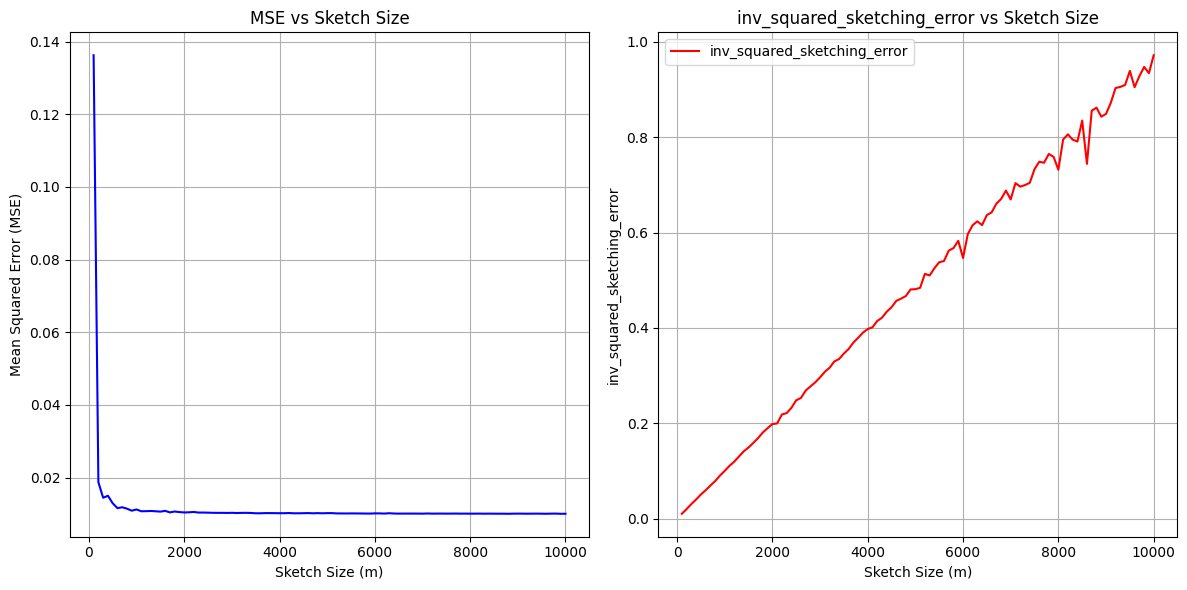

In [26]:
# Plot MSE vs m
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(df_merged["m"], df_merged["MSE"], label="MSE", color='blue')
plt.xlabel("Sketch Size (m)")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE vs Sketch Size")
plt.grid(True)

# Plot Min_SVD_Error and Max_SVD_Error vs m
plt.subplot(1, 2, 2)
plt.plot(df_merged["m"], df_merged["inv_squared_sketching_error"], label="inv_squared_sketching_error", color='red')
plt.xlabel("Sketch Size (m)")
plt.ylabel("inv_squared_sketching_error")
plt.title("inv_squared_sketching_error vs Sketch Size")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

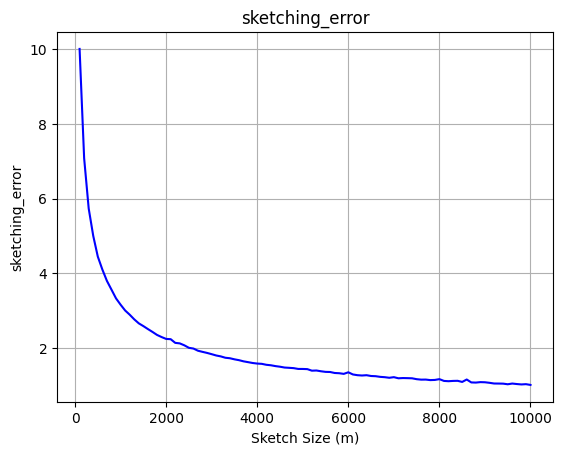

In [27]:
plt.plot(df_merged["m"], df_merged["sketching_error"], label="sketching_error", color='blue')
plt.xlabel("Sketch Size (m)")
plt.ylabel("sketching_error")
plt.title("sketching_error")
plt.grid(True)

## sparsity against mse and sketching error

In [28]:
#varying s, elbow
n, d = 10000, 100  # Matrix size
m = 2000
non_zero_entries_list = list(range(2,m + 1 ,2))
# Store results
results = []

for non_zero_entries in non_zero_entries_list:
    # Compute estimated x
    x_estimated, intercept, min_svd_error, max_svd_error  = fast_least_squares_sgd(A, b, non_zero_entries,m)
    y_pred = A @ x_estimated + intercept
    mse = np.mean((y_pred - b) ** 2)
    # Store results for plotting
    results.append({"m": m, "MSE": mse, "Sparsity": non_zero_entries, "Min_SVD_Error": min_svd_error,"Max_SVD_Error": max_svd_error})

# Combine all results
df_results = pd.DataFrame(results)

In [29]:
df_results['sketching_error'] = df_results[["Min_SVD_Error", "Max_SVD_Error"]].max(axis=1)
df_results["inv_squared_sketching_error"] = 1 / (df_results["sketching_error"] ** 2)
df_results

,m,MSE,Sparsity,Min_SVD_Error,Max_SVD_Error,sketching_error,inv_squared_sketching_error
0,2000,0.010621,2,0.128954,2.655818,2.655818,0.141776
1,2000,0.010493,4,0.017176,2.277990,2.277990,0.192707
2,2000,0.010474,6,0.202425,2.241249,2.241249,0.199076
3,2000,0.010448,8,0.233423,2.241640,2.241640,0.199007
4,2000,0.010509,10,0.237046,2.248374,2.248374,0.197817
...,...,...,...,...,...,...,...
995,2000,0.010643,1992,0.238921,2.226002,2.226002,0.201813
996,2000,0.010534,1994,0.238778,2.232857,2.232857,0.200576
997,2000,0.010383,1996,0.231350,2.231620,2.231620,0.200798
998,2000,0.010436,1998,0.238742,2.233474,2.233474,0.200465


In [30]:
df_results.to_csv('varying_s_data_application.csv', index=False)

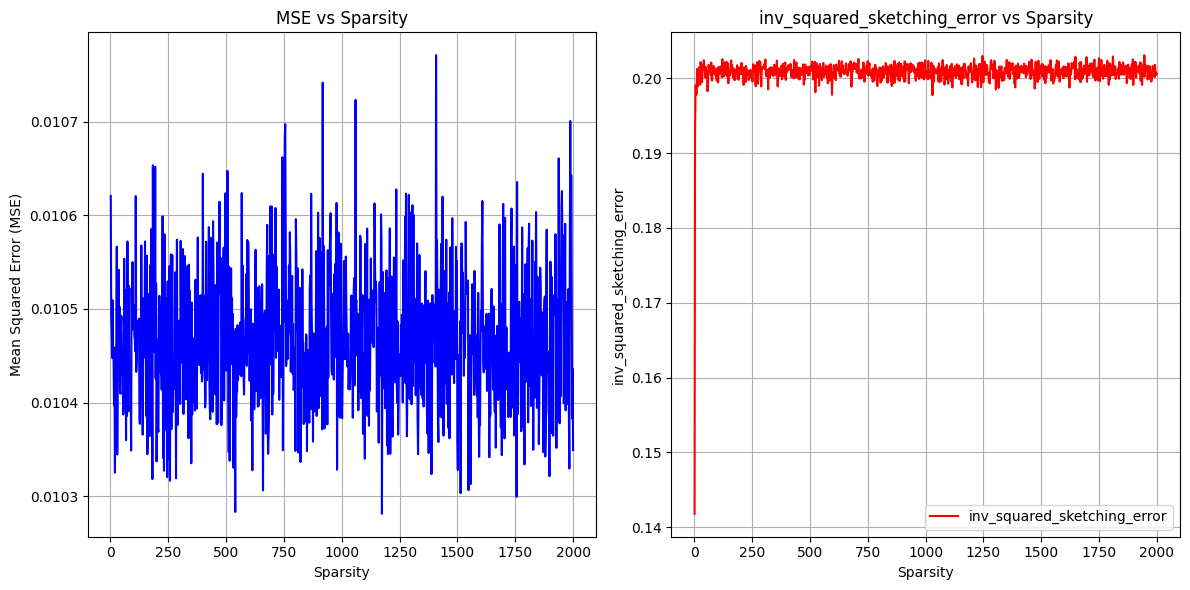

In [31]:
# Plot MSE vs m
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(df_results["Sparsity"], df_results["MSE"], label="MSE", color='blue')
plt.xlabel("Sparsity")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE vs Sparsity")
plt.grid(True)

# Plot Min_SVD_Error and Max_SVD_Error vs m
plt.subplot(1, 2, 2)
plt.plot(df_results["Sparsity"], df_results["inv_squared_sketching_error"], label="inv_squared_sketching_error", color='red')
plt.xlabel("Sparsity")
plt.ylabel("inv_squared_sketching_error")
plt.title("inv_squared_sketching_error vs Sparsity")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

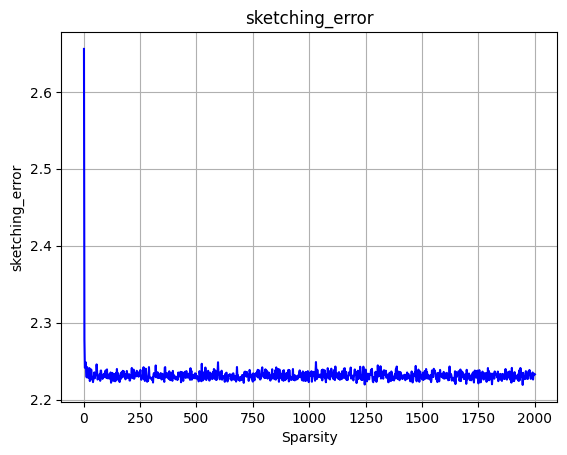

In [32]:
plt.plot(df_results["Sparsity"], df_results["sketching_error"], label="sketching_error", color='blue')
plt.xlabel("Sparsity")
plt.ylabel("sketching_error")
plt.title("sketching_error")
plt.grid(True)

In [33]:
df_filtered = df_results[df_results["Sparsity"] <= 50]

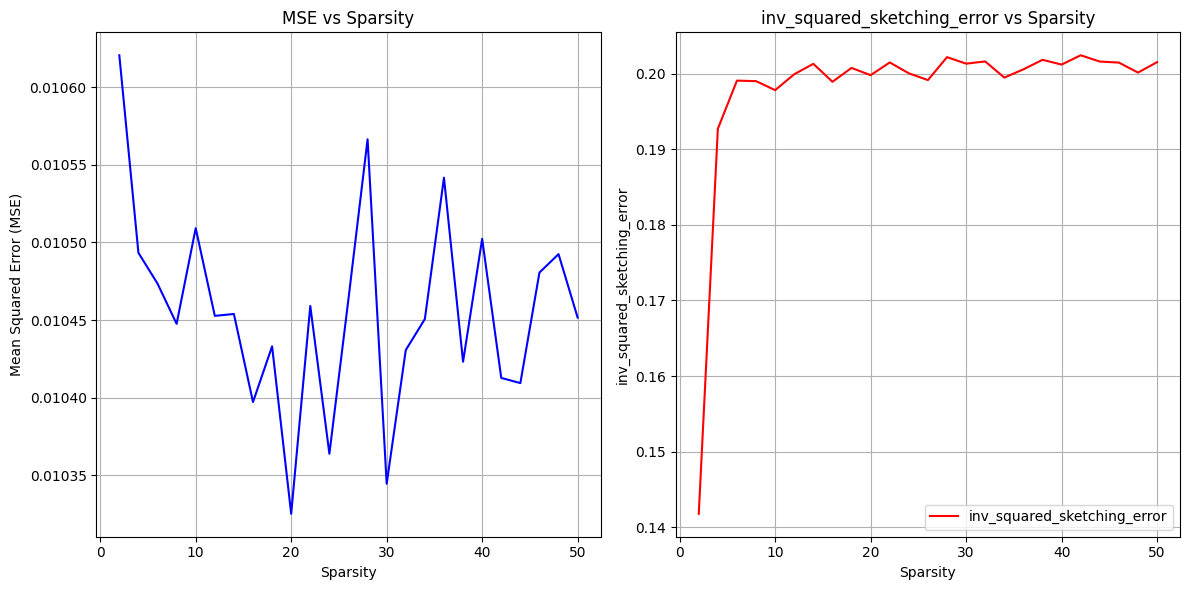

In [34]:
# Plot MSE vs m
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(df_filtered["Sparsity"], df_filtered["MSE"], label="MSE", color='blue')
plt.xlabel("Sparsity")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE vs Sparsity")
plt.grid(True)

# Plot Min_SVD_Error and Max_SVD_Error vs m
plt.subplot(1, 2, 2)
plt.plot(df_filtered["Sparsity"], df_filtered["inv_squared_sketching_error"], label="inv_squared_sketching_error", color='red')
plt.xlabel("Sparsity")
plt.ylabel("inv_squared_sketching_error")
plt.title("inv_squared_sketching_error vs Sparsity")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

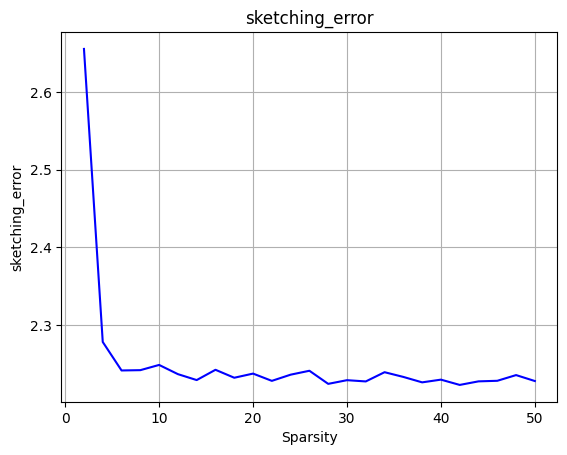

In [35]:
plt.plot(df_filtered["Sparsity"], df_filtered["sketching_error"], label="sketching_error", color='blue')
plt.xlabel("Sparsity")
plt.ylabel("sketching_error")
plt.title("sketching_error")
plt.grid(True)

Conclusion: sparsity after 8 doesnt seem to change drastically. Same for m around 200, mse and sketching error doesnt change as much (elbow method)

# Housing dataset

## Data parsing and processing

In [ ]:
df = pd.read_csv("../Dataset/Housing.csv")
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [108]:
df.isnull().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

In [109]:
X = df.drop(columns=['price'])
y = df['price']
numerical_cols = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
categorical_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 
                    'airconditioning', 'prefarea', 'furnishingstatus']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  # Standardize numerical features
        ('cat', OneHotEncoder(), categorical_cols)   # OneHotEncode categorical features
    ])

X_transformed = preprocessor.fit_transform(X)

### Train test split

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.4, random_state=42)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

### Initialising parameters

In [111]:
non_zero_entries = 10 #sparsity
n, d = X_train.shape 
m = 300 # lesser than n 

## Least square sketched vs regular

In [112]:
x_sgd, x_sgd_intercept, min_svd_error, max_svd_error = fast_least_squares_sgd(X_train, y_train, non_zero_entries, m)

In [113]:
y_pred_sketch = X_test @ x_sgd + x_sgd_intercept
mse_sgd_sketch = mean_squared_error(y_test, y_pred_sketch)
mse_sgd_sketch

1548569915619.7798

In [114]:
X_train_with_intercept = np.c_[np.ones(X_train.shape[0]), X_train]
x_ols, _, _, _ = np.linalg.lstsq(X_train_with_intercept, y_train, rcond=None)
X_test_with_intercept = np.c_[np.ones(X_test.shape[0]), X_test]
y_pred_ols = X_test_with_intercept @ x_ols
mse_ols = mean_squared_error(y_test, y_pred_ols)
mse_ols

1506230725917.4587

### Compare the difference in mse

In [115]:
relative_difference = abs(mse_sgd_sketch - mse_ols) / mse_ols
print(relative_difference)
mse_ratio = mse_sgd_sketch / mse_ols
print(mse_ratio)

0.028109365300944756
1.0281093653009448


2.8% difference and a ratio close 1 suggest the sketching method is very close to the non-sketching OLS.

# Student performance dataset

## Data parsing and processing

In [175]:
df = pd.read_csv("../Dataset/Student_Performance.csv")
df.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [176]:
df['Extracurricular Activities'] = df['Extracurricular Activities'].map({'Yes': 1, 'No': 0})
df.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,1,9,1,91.0
1,4,82,0,4,2,65.0
2,8,51,1,7,2,45.0
3,5,52,1,5,2,36.0
4,7,75,0,8,5,66.0


In [177]:
df.isnull().sum()

Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64

In [178]:
df.shape

(10000, 6)

In [179]:
X = df.drop(columns='Performance Index')
y = df['Performance Index']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [180]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
X_train.shape

(8000, 5)

## Initialising parameters

In [181]:
non_zero_entries = 10 #sparsity (<m)
n, d = X_train.shape 
m = 2000 # lesser than n 

### Regular ols

In [182]:
X_train_with_intercept = np.c_[np.ones(X_train.shape[0]), X_train]
x_ols, _, _, _ = np.linalg.lstsq(X_train_with_intercept, y_train, rcond=None)
X_test_with_intercept = np.c_[np.ones(X_test.shape[0]), X_test]
y_pred_ols = X_test_with_intercept @ x_ols
mse_ols = mean_squared_error(y_test, y_pred_ols)
mse_ols

4.082628398521851

### Ridge regression

In [183]:
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
x_ridge = ridge_model.coef_
intercept_ridge = ridge_model.intercept_
y_pred_ridge = ridge_model.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mse_ridge

4.083211367310288

### Sketched ols

In [ ]:
x_sgd, x_sgd_intercept, min_svd_error, max_svd_error = fast_least_squares_sgd(X_train, y_train, non_zero_entries, m)
y_pred_sketch = X_test @ x_sgd + x_sgd_intercept
mse_sgd_sketch = mean_squared_error(y_test, y_pred_sketch)
mse_sgd_sketch

4.0880226800842046

### Sketched regularised

In [185]:
x_sketch_reg, x_sketch_reg_intercept, _, min_svd_error, max_svd_error = fast_least_squares_sgd_regularized(X_train, y_train, non_zero_entries, m, lambda_reg=1e-3)
y_pred_sketch_reg = X_test @ x_sketch_reg + x_sketch_reg_intercept
mse_sgd_sketch_reg = mean_squared_error(y_test, y_pred_sketch_reg)
mse_sgd_sketch_reg

4.10156274108831

## Further analysis

Sketched non reg

In [186]:
non_zero_entries = 10 #sparsity (<m)
n, d = X_train.shape 
m = 2000 # lesser than n 
iterations = 10
min_svd_errors = []
max_svd_errors = []
x_sgd_results = []
mse_list = []
intercept_list = []

# Iterate over the number of iterations
for i in range(iterations):
    x_sgd, intercept, min_svd_error, max_svd_error = fast_least_squares_sgd(X_train, y_train, non_zero_entries, m)
    x_sgd_results.append(x_sgd)
    min_svd_errors.append(min_svd_error)
    max_svd_errors.append(max_svd_error)
    intercept_list.append(intercept)
    y_pred_sgd = X_test @ x_sgd + intercept
    mse_sgd_reg = mean_squared_error(y_test, y_pred_sgd)
    mse_list.append(mse_sgd_reg)


x_sgd_sketch_results_df = pd.DataFrame(x_sgd_results)
x_sgd_sketch_results_df["intercept"] = intercept_list
x_sgd_sketch_results_df["min_svd_error"] = min_svd_errors
x_sgd_sketch_results_df["max_svd_error"] = max_svd_errors
x_sgd_sketch_results_df["mse"] = mse_list

In [187]:
x_sgd_sketch_results_df

,0,1,2,3,4,intercept,min_svd_error,max_svd_error,mse
0,7.329925,17.659035,0.319150,0.885352,0.574679,55.243684,0.006191,2.016192,4.081992
1,7.411150,17.627426,0.243237,0.791949,0.546519,55.175451,0.000134,1.993355,4.085853
2,7.345685,17.644196,0.278310,0.776726,0.524035,55.191972,0.002784,2.000924,4.083905
3,7.398901,17.639075,0.319947,0.925250,0.485172,55.299289,0.028682,2.003644,4.108356
4,7.349048,17.609710,0.345090,0.829080,0.498031,55.213507,0.002200,2.009825,4.093497
5,7.431855,17.632539,0.350482,0.810165,0.544965,55.231932,0.002352,2.010102,4.085278
6,7.393198,17.582040,0.216608,0.694514,0.586461,55.266697,0.004385,2.027468,4.132735
7,7.408582,17.588459,0.263772,0.815723,0.457817,55.298110,0.001049,2.016200,4.127243
8,7.311372,17.659612,0.350967,0.728271,0.550614,55.302437,0.000601,2.005904,4.109861
9,7.358013,17.658863,0.292422,0.859218,0.536785,55.224585,0.000393,1.994030,4.077300


## Sketched reg

In [188]:
intercept_list = []
min_svd_errors = []
max_svd_errors = []
x_sgd_reg_results = []
mse_list = []

# Iterate over the number of iterations
for i in range(iterations):
    x_sgd_reg, reg_intercept, _, min_svd_error, max_svd_error = fast_least_squares_sgd_regularized(X_train, y_train, non_zero_entries,m, lambda_reg=1e-3)
    x_sgd_reg_results.append(x_sgd_reg)
    intercept_list.append(reg_intercept)
    min_svd_errors.append(min_svd_error)
    max_svd_errors.append(max_svd_error)
    y_pred_sgd_reg = X_test @ x_sgd_reg + reg_intercept
    mse_sgd_reg = mean_squared_error(y_test, y_pred_sgd_reg)
    mse_list.append(mse_sgd_reg)


x_sgd_results_reg_df = pd.DataFrame(x_sgd_reg_results)
x_sgd_results_reg_df["intercept"] = intercept_list
x_sgd_results_reg_df["min_svd_error"] = min_svd_errors
x_sgd_results_reg_df["max_svd_error"] = max_svd_errors
x_sgd_results_reg_df["mse"] = mse_list

In [189]:
x_sgd_results_reg_df

,0,1,2,3,4,intercept,min_svd_error,max_svd_error,mse
0,7.381896,17.602155,0.305604,0.770140,0.477408,55.311964,0.003621,2.009706,4.123462
1,7.334460,17.656616,0.323115,0.813272,0.570129,55.223637,0.000446,2.007246,4.077752
2,7.400736,17.664684,0.305809,0.754840,0.563678,55.220385,0.003060,1.999384,4.079139
3,7.336214,17.615201,0.267261,0.737243,0.547178,55.190987,0.003523,2.009754,4.097605
4,7.410343,17.672875,0.299451,0.825624,0.522576,55.265440,0.005321,2.021129,4.081471
5,7.417282,17.645488,0.276876,0.812381,0.480014,55.232582,0.000704,2.018994,4.090276
6,7.348389,17.653118,0.301825,0.769930,0.600197,55.215716,0.003160,2.009141,4.080593
7,7.383190,17.641834,0.218937,0.740719,0.589162,55.223570,0.000483,2.024516,4.095287
8,7.407602,17.597680,0.369381,0.801799,0.596830,55.286784,0.000787,2.005364,4.106780
9,7.327338,17.615389,0.337344,0.848906,0.554070,55.152242,0.004979,2.001485,4.085522


In [196]:
x_sgd_sketch_results_df["x_array"] = x_sgd_sketch_results_df.iloc[:, 0:6].apply(lambda row: row.values, axis=1)
x_sgd_sketch_results_df.head()

,0,1,2,3,4,intercept,min_svd_error,max_svd_error,mse,x_array
0,7.329925,17.659035,0.319150,0.885352,0.574679,55.243684,0.006191,2.016192,4.081992,"[7.3299246760119185, 17.659035115681966, 0.319..."
1,7.411150,17.627426,0.243237,0.791949,0.546519,55.175451,0.000134,1.993355,4.085853,"[7.411149502353151, 17.627425916262887, 0.2432..."
2,7.345685,17.644196,0.278310,0.776726,0.524035,55.191972,0.002784,2.000924,4.083905,"[7.345685379607035, 17.644196012011655, 0.2783..."
3,7.398901,17.639075,0.319947,0.925250,0.485172,55.299289,0.028682,2.003644,4.108356,"[7.398900708196985, 17.63907504402326, 0.31994..."
4,7.349048,17.609710,0.345090,0.829080,0.498031,55.213507,0.002200,2.009825,4.093497,"[7.34904801217041, 17.60971029681317, 0.345090..."


In [205]:
x_sgd_results_reg_df["x_array"] = x_sgd_results_reg_df.iloc[:, 0:6].apply(lambda row: row.values, axis=1)
x_sgd_results_reg_df.head()

,0,1,2,3,4,intercept,min_svd_error,max_svd_error,mse,x_array
0,7.381896,17.602155,0.305604,0.770140,0.477408,55.311964,0.003621,2.009706,4.123462,"[7.381895528995307, 17.602154921005155, 0.3056..."
1,7.334460,17.656616,0.323115,0.813272,0.570129,55.223637,0.000446,2.007246,4.077752,"[7.334460091107569, 17.656615830424073, 0.3231..."
2,7.400736,17.664684,0.305809,0.754840,0.563678,55.220385,0.003060,1.999384,4.079139,"[7.400736075671658, 17.664683996411828, 0.3058..."
3,7.336214,17.615201,0.267261,0.737243,0.547178,55.190987,0.003523,2.009754,4.097605,"[7.336214445525732, 17.61520054036147, 0.26726..."
4,7.410343,17.672875,0.299451,0.825624,0.522576,55.265440,0.005321,2.021129,4.081471,"[7.410342595181117, 17.672875021453756, 0.2994..."


In [201]:
intercept_ridge

55.240765157034126

In [200]:
ridge_coef = np.append(x_ridge,intercept_ridge)
ridge_coef

array([ 7.38465051, 17.63468517,  0.30426091,  0.80869184,  0.54998809,
       55.24076516])

In [202]:
ols_coef = np.append(x_ols[1:],x_ols[0])
ols_coef

array([ 7.38559242, 17.63689926,  0.30429188,  0.80878696,  0.55001995,
       55.2407568 ])

## Compare distance of coeff

non reg sketch vs non sketch

In [203]:
distances = []
for index, row in x_sgd_sketch_results_df.iterrows():
    # Extract x_sgd_array from each row
    x_sgd_array = row['x_array']
    # Calculate the distance from regression_coeff
    distance = np.linalg.norm(x_sgd_array - ols_coef)
    # Append the calculated distance
    distances.append(distance)

# Assign the calculated distances to the new 'distance' column
x_sgd_sketch_results_df['distance'] = distances
x_sgd_sketch_results_df.head()

,0,1,2,3,4,intercept,min_svd_error,max_svd_error,mse,x_array,distance
0,7.329925,17.659035,0.319150,0.885352,0.574679,55.243684,0.006191,2.016192,4.081992,"[7.3299246760119185, 17.659035115681966, 0.319...",0.101432
1,7.411150,17.627426,0.243237,0.791949,0.546519,55.175451,0.000134,1.993355,4.085853,"[7.411149502353151, 17.627425916262887, 0.2432...",0.095033
2,7.345685,17.644196,0.278310,0.776726,0.524035,55.191972,0.002784,2.000924,4.083905,"[7.345685379607035, 17.644196012011655, 0.2783...",0.080025
3,7.398901,17.639075,0.319947,0.925250,0.485172,55.299289,0.028682,2.003644,4.108356,"[7.398900708196985, 17.63907504402326, 0.31994...",0.147044
4,7.349048,17.609710,0.345090,0.829080,0.498031,55.213507,0.002200,2.009825,4.093497,"[7.34904801217041, 17.60971029681317, 0.345090...",0.087158


Reg Sketch vs non sketch

In [ ]:
distances = []
for index, row in x_sgd_results_reg_df.iterrows():
    # Extract x_sgd_array from each row
    x_sgd_array = row['x_array']
    # Calculate the distance from regression_coeff
    distance = np.linalg.norm(x_sgd_array - ridge_coef)
    # Append the calculated distance
    distances.append(distance)

# Assign the calculated distances to the new 'distance' column
x_sgd_results_reg_df['distance'] = distances
x_sgd_results_reg_df.head()

,0,1,2,3,4,intercept,min_svd_error,max_svd_error,mse,x_array,distance
0,7.381896,17.602155,0.305604,0.770140,0.477408,55.311964,0.003621,2.009706,4.123462,"[7.381895528995307, 17.602154921005155, 0.3056...",0.113539
1,7.334460,17.656616,0.323115,0.813272,0.570129,55.223637,0.000446,2.007246,4.077752,"[7.334460091107569, 17.656615830424073, 0.3231...",0.063840
2,7.400736,17.664684,0.305809,0.754840,0.563678,55.220385,0.003060,1.999384,4.079139,"[7.400736075671658, 17.664683996411828, 0.3058...",0.068292
3,7.336214,17.615201,0.267261,0.737243,0.547178,55.190987,0.003523,2.009754,4.097605,"[7.336214445525732, 17.61520054036147, 0.26726...",0.108099
4,7.410343,17.672875,0.299451,0.825624,0.522576,55.265440,0.005321,2.021129,4.081471,"[7.410342595181117, 17.672875021453756, 0.2994...",0.061552


Sketching error

In [207]:
x_sgd_sketch_results_df['sketching_error'] = x_sgd_sketch_results_df[["min_svd_error", "max_svd_error"]].max(axis=1)
x_sgd_results_reg_df['sketching_error'] = x_sgd_results_reg_df[["min_svd_error", "max_svd_error"]].max(axis=1)

In [209]:
x_sgd_sketch_results_df.head()

,0,1,2,3,4,intercept,min_svd_error,max_svd_error,mse,x_array,distance,sketching_error
0,7.329925,17.659035,0.319150,0.885352,0.574679,55.243684,0.006191,2.016192,4.081992,"[7.3299246760119185, 17.659035115681966, 0.319...",0.101432,2.016192
1,7.411150,17.627426,0.243237,0.791949,0.546519,55.175451,0.000134,1.993355,4.085853,"[7.411149502353151, 17.627425916262887, 0.2432...",0.095033,1.993355
2,7.345685,17.644196,0.278310,0.776726,0.524035,55.191972,0.002784,2.000924,4.083905,"[7.345685379607035, 17.644196012011655, 0.2783...",0.080025,2.000924
3,7.398901,17.639075,0.319947,0.925250,0.485172,55.299289,0.028682,2.003644,4.108356,"[7.398900708196985, 17.63907504402326, 0.31994...",0.147044,2.003644
4,7.349048,17.609710,0.345090,0.829080,0.498031,55.213507,0.002200,2.009825,4.093497,"[7.34904801217041, 17.60971029681317, 0.345090...",0.087158,2.009825


In [210]:
x_sgd_results_reg_df.head()

,0,1,2,3,4,intercept,min_svd_error,max_svd_error,mse,x_array,distance,sketching_error
0,7.381896,17.602155,0.305604,0.770140,0.477408,55.311964,0.003621,2.009706,4.123462,"[7.381895528995307, 17.602154921005155, 0.3056...",0.113539,2.009706
1,7.334460,17.656616,0.323115,0.813272,0.570129,55.223637,0.000446,2.007246,4.077752,"[7.334460091107569, 17.656615830424073, 0.3231...",0.063840,2.007246
2,7.400736,17.664684,0.305809,0.754840,0.563678,55.220385,0.003060,1.999384,4.079139,"[7.400736075671658, 17.664683996411828, 0.3058...",0.068292,1.999384
3,7.336214,17.615201,0.267261,0.737243,0.547178,55.190987,0.003523,2.009754,4.097605,"[7.336214445525732, 17.61520054036147, 0.26726...",0.108099,2.009754
4,7.410343,17.672875,0.299451,0.825624,0.522576,55.265440,0.005321,2.021129,4.081471,"[7.410342595181117, 17.672875021453756, 0.2994...",0.061552,2.021129


## New function without calculating svd to reduce time

In [ ]:
def fast_least_squares_sgd(A, b, non_zero_entries, m, T=100, eta=0.01, gamma=0.1, batch_size=10):
    n, d = A.shape
    # Add a column of ones to A to include intercept term
    A = np.c_[np.ones(n), A]

    # Step 1: Generate the sketch matrix S using the sketch_matrix function
    S = sketch_matrix(m, n, non_zero_entries)
    # Step 2: Compute SA and Sb
    SA = S @ A
    Sb = S @ b

    # Step 3: Compute QR decomposition of SA
    Q, R_inv = np.linalg.qr(SA)
    R = np.linalg.inv(R_inv)

    # Step 4: Compute leverage score estimates
    leverage_scores = estimate_leverage_scores(A, R, gamma)
    leverage_probs = leverage_scores / np.sum(leverage_scores)  # Normalize

    # Step 5: Compute initial x0 by solving (SAx = Sb)
    x = np.linalg.lstsq(SA, Sb, rcond=None)[0]

    # Step 6: Perform mini-batch SGD
    for t in range(T):
        # Step 6.1: Sample batch indices based on leverage scores
        batch_indices = np.random.choice(n, size=batch_size, p=leverage_probs)
        
        # Step 6.2: Construct StA and Stb for mini-batch
        StA = A[batch_indices]
        Stb = b[batch_indices]

        # Step 6.3: Compute gradient of the least squares loss
        gt = 2 * StA.T @ (StA @ x - Stb)

        # Step 6.4: Update x using preconditioned gradient
        x = x - eta * R @ (R.T @ gt)
    intercept = x[0]

    return x[1:] , intercept

def fast_least_squares_sgd_regularized(A, b, non_zero_entries, m, lambda_reg, T=100, eta=0.01, gamma=0.1, batch_size=10):
    n, d = A.shape
    A = np.c_[np.ones(n), A]
    
    # Step 1: Compute effective dimension and scaled regularization λ'
    d_lambda = compute_effective_dimension(A, lambda_reg)
    lambda_scaled = lambda_reg * (1 - d_lambda / m)

    # Step 2: Generate sketch matrix
    S = sketch_matrix(m, n, non_zero_entries)
    # Step 3: Compute SA and Sb
    SA = S @ A
    Sb = S @ b

    # Step 4: Compute QR decomposition of SA
    Q, R_inv = np.linalg.qr(SA)
    R = np.linalg.inv(R_inv)

    # Step 5: Compute leverage scores
    leverage_scores = estimate_leverage_scores(A, R, gamma)
    leverage_probs = leverage_scores / np.sum(leverage_scores)  # Normalize

    # Step 6: Solve for initial x0 using regularized least squares
    I_d = np.eye(d+1)
    x = np.linalg.solve(SA.T @ SA + lambda_scaled * I_d, SA.T @ Sb)

    # Step 7: Perform mini-batch SGD
    for t in range(T):
        # Sample batch indices based on leverage scores
        batch_indices = np.random.choice(n, size=batch_size, p=leverage_probs)
        
        # Construct StA and Stb for mini-batch
        StA = A[batch_indices]
        Stb = b[batch_indices]

        # Compute gradient with regularization
        gt = 2 * (StA.T @ (StA @ x - Stb) + lambda_scaled * x)

        # Update x using preconditioned gradient
        x = x - eta * R @ (R.T @ gt)

    intercept = x[0]

    return x[1:], intercept, lambda_scaled